# One-zone models - effect of two-infall parameters

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import vice
import paths
from multizone.src.yields import J21
from multizone.src.models import twoinfall, insideout
from track_and_mdf import setup_figure, plot_vice_onezone
from vice.toolkit import J21_sf_law
from multizone.src import dtds
import _globals

In [2]:
plt.style.use(paths.styles / 'paper.mplstyle')
plt.rcParams['figure.dpi'] = 200

In [3]:
output_dir = paths.data / 'onezone' / 'twoinfall'
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
dt = 0.01
tmax = _globals.END_TIME
simtime = np.arange(0, tmax+dt, dt)

In [5]:
r = 8
dr = 0.1
zone_area = np.pi * ((r+dr)**2 - r**2)

Re-calculate the amplitude ratio with parameters eta and tau_star (the twoinfall module assumes the J21 SF law and the default mass loading factor).

In [6]:
default_tau_star = lambda time, mgas: 2

def twoinfall_ampratio(time_dependence, radius, onset = 4,
                       dt = 0.01, dr = 0.1, recycling = 0.4,
                       eta=2., tau_star=default_tau_star):
    mgas = 0
    time = 0
    mstar = 0
    mstar_at_onset = None
    while time < _globals.END_TIME:
        sfr = mgas / tau_star(time, mgas) # msun / Gyr
        mgas += time_dependence(time) * dt * 1.e9 # yr-Gyr conversion
        mgas -= sfr * dt * (1 + eta - recycling)
        mstar += sfr * dt * (1 - recycling)
        if mstar_at_onset is None and time >= onset: mstar_at_onset = mstar
        time += dt
    thick_to_thin = _globals.THICK_TO_THIN_RATIO * m.exp(
        radius * (1 / _globals.THIN_DISK_SCALE_RADIUS - 1 / _globals.THICK_DISK_SCALE_RADIUS))
    return mstar / (mstar - mstar_at_onset) * (1 + thick_to_thin)**-1

In [7]:
def twoinfall_ampratio_analytic(radius, first_timescale=1, second_timescale=4, onset=4, tmax=_globals.END_TIME):
    thick_to_thin_ratio = _globals.THICK_TO_THIN_RATIO * m.exp(
        radius * (1 / _globals.THIN_DISK_SCALE_RADIUS - 1 / _globals.THICK_DISK_SCALE_RADIUS))
    ampratio = first_timescale * (1 - m.exp(-tmax / first_timescale))
    ampratio *= 1 / (second_timescale * (1 - m.exp(-(tmax - onset) / second_timescale)))
    ampratio *= 1 / thick_to_thin_ratio
    return ampratio

In [8]:
ifr = twoinfall(8)
area = m.pi * (8.1**2 - 8**2)
print(twoinfall_ampratio(ifr, 8, eta=2, tau_star=default_tau_star))
print(twoinfall_ampratio(ifr, 8, eta=20, tau_star=default_tau_star))
print(twoinfall_ampratio(ifr, 8, eta=0, tau_star=default_tau_star))
print(twoinfall_ampratio(ifr, 8, eta=2, tau_star=J21_sf_law(area)))
print(twoinfall_ampratio_analytic(8))

1.1029484886047112
1.1088240700729841
1.0359937365913725
1.0990625628911606
2.290305625140822


## Onset time

In [9]:
def setup_onezone(name, func, r=8, dr=0.1, mode='ifr', tau_star=2, eta=2., Zin=0.):
    # zone_area = np.pi * ((r+dr)**2 - r**2)
    # tau_star = J21_sf_law(zone_area)
    sz = vice.singlezone(
        name=name,
        func=func,
        mode=mode,
        elements=('fe', 'o'),
        eta=eta,
        Zin=Zin,
        delay=0.04,
        RIa=dtds.exponential(timescale=1.5),
        Mg0=0,
        tau_star=tau_star,
        dt=dt,
        bins=[i*0.01 - 3 for i in range(401)],
    )
    return sz

Run one-zone models with different onset times for the second infall

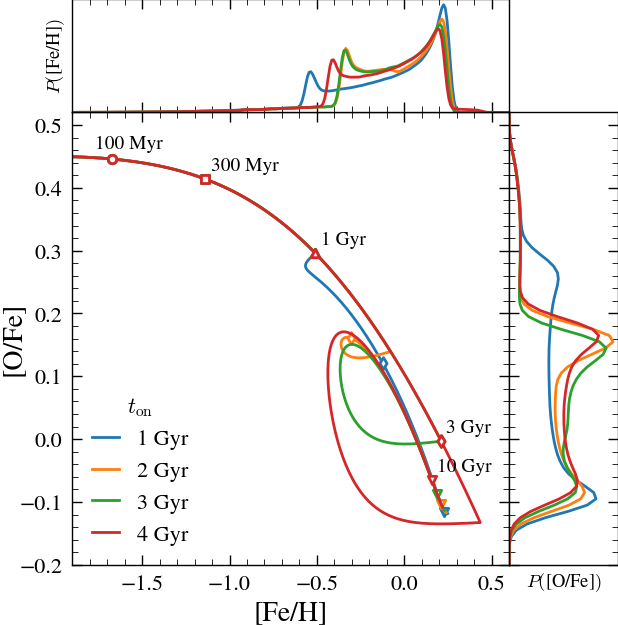

In [10]:
fig, axs = setup_figure(xlim=(-1.9, 0.6), ylim=(-0.2, 0.52))

onset_times = [1, 2, 3, 4]
for ton in onset_times:
    ifr = twoinfall(8, onset=ton)
    ifr.ratio = twoinfall_ampratio(ifr, 8, onset=ton)
    name = str(output_dir / f'onset{ton}')
    sz = setup_onezone(name, ifr)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{ton} Gyr',
                      marker_labels=(ton==4))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$t_{\rm on}$')
plt.show()

The high [O/Fe] peak is produced during the turn-over after the onset of the second infall. As illustrated below, this is due to a high SFR coincident with a slowing of the change in [O/Fe]. The low-[O/Fe] peak represents the equilibrium abundance after the second infall.

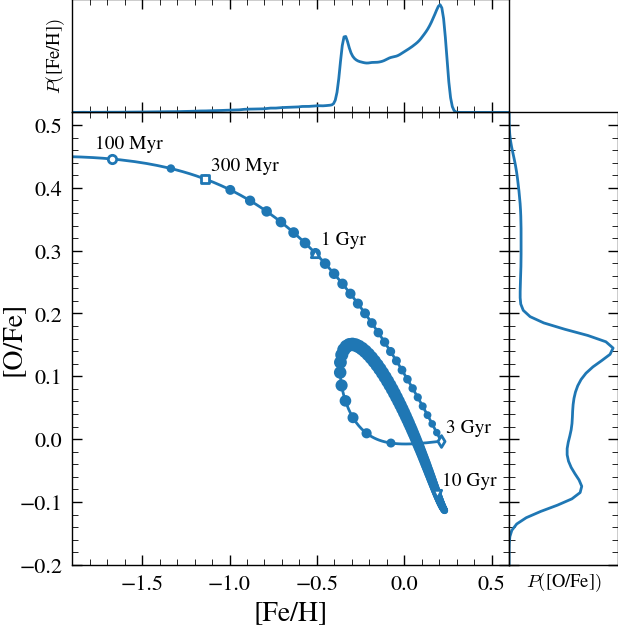

In [11]:
fig, axs = setup_figure(xlim=(-1.9, 0.6), ylim=(-0.2, 0.52))

name = str(output_dir / 'onset3')
plot_vice_onezone(name, fig=fig, axs=axs,
                  label=f'{ton} Gyr',
                  marker_labels=True)
hist = vice.history(name)
axs[0].scatter(hist['[fe/h]'][::10], hist['[o/fe]'][::10], s=[50*h for h in hist['sfr'][::10]])

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
plt.show()

The onset time of the second infall doesn't have a big effect on the abundance distributions as long as it's above ~2 Gyr, because much of the gas from the first infall has been depleted.

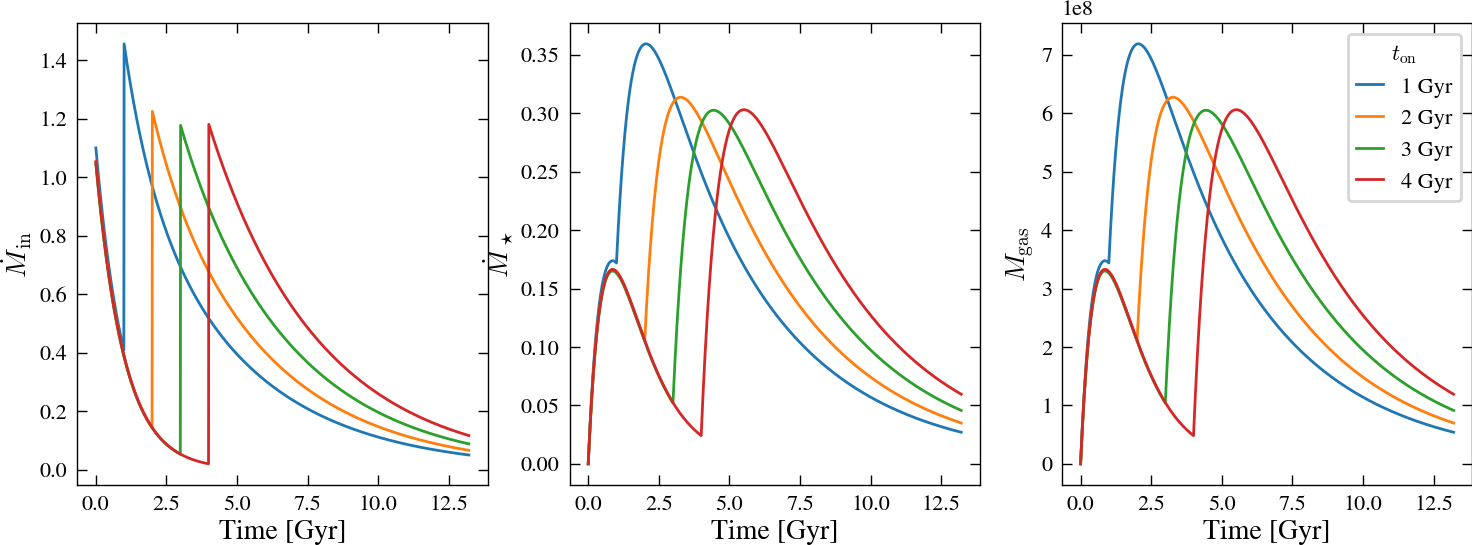

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for ton in onset_times:
    name = str(output_dir / f'onset{ton}')
    hist = vice.history(name)
    axs[0].plot(hist['time'], hist['ifr'], '-')
    axs[1].plot(hist['time'], hist['sfr'], '-')
    axs[2].plot(hist['time'], hist['mgas'], '-', label=f'{ton} Gyr')
    
axs[2].legend(title=r'$t_{\rm on}$')
for ax in axs:
    ax.set_xlabel('Time [Gyr]')
axs[0].set_ylabel(r'$\dot M_{\rm in}$')
axs[1].set_ylabel(r'$\dot M_\star$')
axs[2].set_ylabel(r'$M_{\rm gas}$')
plt.show()

## Inflow timescales

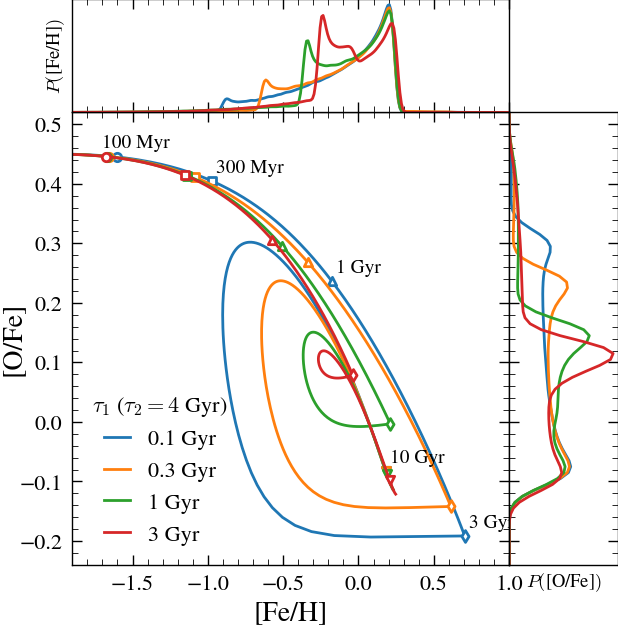

In [13]:
fig, axs = setup_figure(xlim=(-1.9, 1.), ylim=(-0.24, 0.52))

t1_list = [0.1, 0.3, 1, 3]
t2 = 4
ton = 3
for t1 in t1_list:
    ifr = twoinfall(8, first_timescale=t1, second_timescale=t2, onset=ton)
    ifr.ratio = twoinfall_ampratio(ifr, 8, onset=ton)
    name = str(output_dir / f'first{int(t1*10):02d}_second4')
    sz = setup_onezone(name, ifr)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{t1} Gyr',
                      marker_labels=(t1==0.1))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\tau_1$ ($\tau_2=%s$ Gyr)' % t2)
plt.show()

Changing the timescale of the first infall changes the size of the loop. A short timescale produces a bigger loop. This affects the location of the high-[O/Fe] and low-[Fe/H] bumps, but the peak of the MDF and the low-[O/Fe] bump remain the same because they are primarily affected by the second infall.

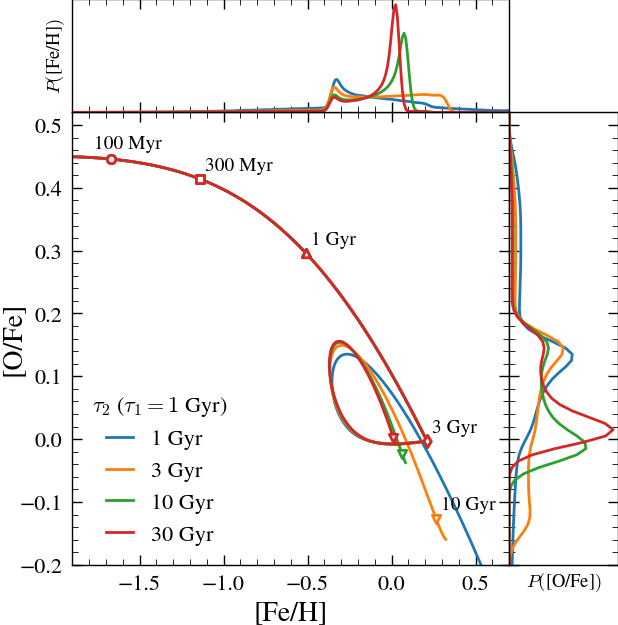

In [14]:
fig, axs = setup_figure(xlim=(-1.9, 0.7), ylim=(-0.2, 0.52))

t1 = 1
t2_list = [1, 3, 10, 30]
ton = 3
for t2 in t2_list:
    ifr = twoinfall(8, first_timescale=t1, second_timescale=t2, onset=ton)
    ifr.ratio = twoinfall_ampratio(ifr, 8, onset=ton)
    name = str(output_dir / f'first{int(t1*10):02d}_second{t2}')
    sz = setup_onezone(name, ifr)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{t2} Gyr',
                      marker_labels=(t2==3))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\tau_2$ ($\tau_1=%s$ Gyr)' % t1)
plt.show()

The second infall timescale affects the shape of the MDF and the lower peak of the [O/Fe] distribution. The 1 Gyr timescale depletes the gas resevoir before the end of the simulation, so the gas abundance changes rapidly from SN Ia enrichment but not many stars are produced in the low-[O/Fe] regime.

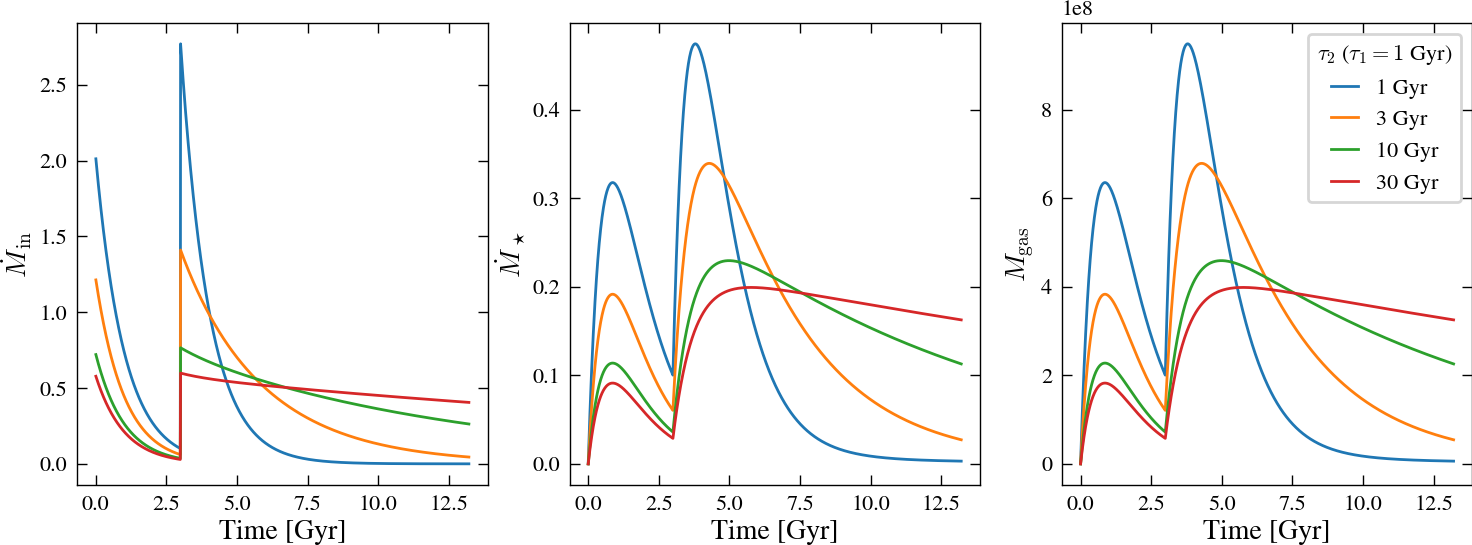

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
t1 = 1
t2_list = [1, 3, 10, 30]
for t2 in t2_list:
    name = str(output_dir / f'first{int(t1*10):02d}_second{t2}')
    hist = vice.history(name)
    axs[0].plot(hist['time'], hist['ifr'], '-')
    axs[1].plot(hist['time'], hist['sfr'], '-')
    axs[2].plot(hist['time'], hist['mgas'], '-', label=f'{t2} Gyr')
    
axs[2].legend(title=r'$\tau_2$ ($\tau_1=%s$ Gyr)' % t1)
for ax in axs:
    ax.set_xlabel('Time [Gyr]')
axs[0].set_ylabel(r'$\dot M_{\rm in}$')
axs[1].set_ylabel(r'$\dot M_\star$')
axs[2].set_ylabel(r'$M_{\rm gas}$')
plt.show()

## Star formation efficiency

1.1046933323765171
1.0966220745809947
1.0940728296973352
1.078899518119707
1.1023453097116644


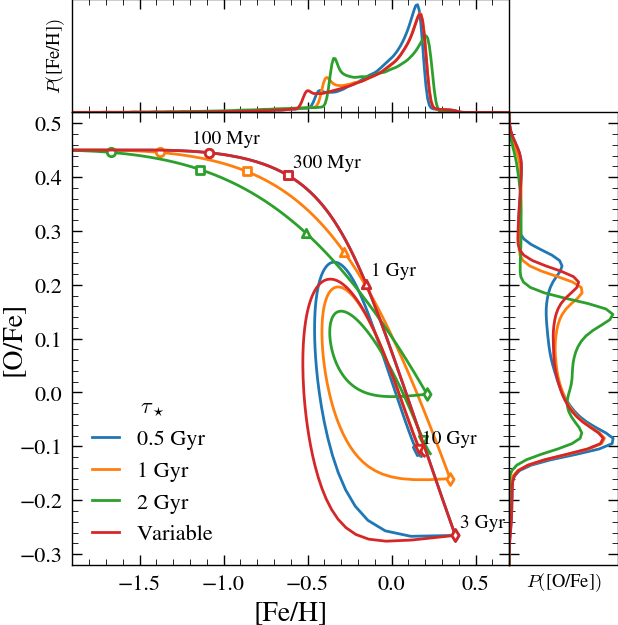

In [16]:
fig, axs = setup_figure(xlim=(-1.9, 0.7), ylim=(-0.32, 0.52))

ifr = twoinfall(8, onset=3, first_timescale=1, second_timescale=4)
print(ifr.ratio)

tau_star_list = [0.5, 1, 2]
for tau_star in tau_star_list:
    name = str(output_dir / f'taustar{int(tau_star*10):02d}')
    ifr.ratio = twoinfall_ampratio(ifr, 8, onset=3, tau_star=lambda time, mgas: tau_star)
    print(ifr.ratio)
    sz = setup_onezone(name, ifr, tau_star=tau_star)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{tau_star} Gyr',
                      marker_labels=(tau_star==0.5))

# Variable tau_star
def tau_star_var(t, onset=3):
    if t < onset:
        return 0.5
    else:
        return 1.

name = str(output_dir / 'taustar_var')
ifr.ratio = twoinfall_ampratio(ifr, 8, onset=3, tau_star=lambda time, mgas: tau_star_var(time))
print(ifr.ratio)
sz = setup_onezone(name, ifr, tau_star=tau_star_var)
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='Variable',
                  marker_labels=False)

# name = str(output_dir / 'taustar_J21')
# tau_star = J21_sf_law(np.pi * ((8.1)**2 - 8**2))
# sz = vice.singlezone(
#     name=name,
#     func=func,
#     mode='ifr',
#     elements=('fe', 'o'),
#     eta=vice.milkyway.default_mass_loading(8),
#     delay=0.04,
#     RIa=dtds.exponential(timescale=1.5),
#     Mg0=0,
#     tau_star=tau_star,
#     dt=dt,
#     bins=[i*0.01 - 3 for i in range(401)],
# )
# sz.run(simtime, overwrite=True)
# plot_vice_onezone(name, fig=fig, axs=axs,
#                   label='J21',
#                   marker_labels=False)

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\tau_\star$')
plt.show()

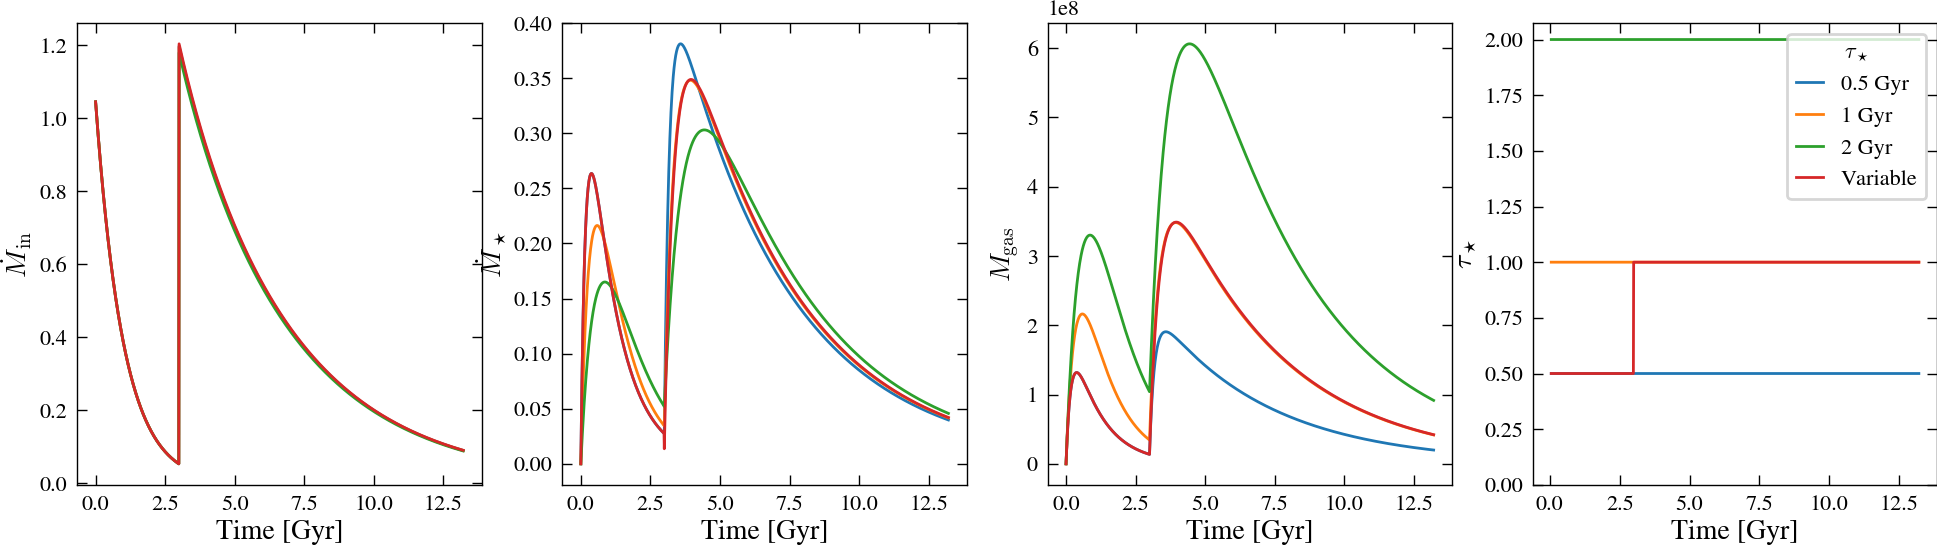

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
name_list = ['taustar05', 'taustar10', 'taustar20', 'taustar_var']
label_list = ['0.5 Gyr', '1 Gyr', '2 Gyr', 'Variable']
for i, name in enumerate(name_list):
    name = str(output_dir / name)
    hist = vice.history(name)
    axs[0].plot(hist['time'], hist['ifr'], '-')
    axs[1].plot(hist['time'], hist['sfr'], '-')
    axs[2].plot(hist['time'], hist['mgas'], '-')
    axs[3].plot(hist['time'][5:], [1e-9 * mg / sfr for mg, sfr in zip(hist['mgas'], hist['sfr'])][5:], '-', label=label_list[i])
    
axs[3].legend(title=r'$\tau_\star$')
for ax in axs:
    ax.set_xlabel('Time [Gyr]')
axs[0].set_ylabel(r'$\dot M_{\rm in}$')
axs[1].set_ylabel(r'$\dot M_\star$')
axs[2].set_ylabel(r'$M_{\rm gas}$')
axs[3].set_ylabel(r'$\tau_\star$')
axs[3].set_ylim((0, None))
plt.show()

## Outflows

/home/lodubay/anaconda3/lib/python3.10/site-packages/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)


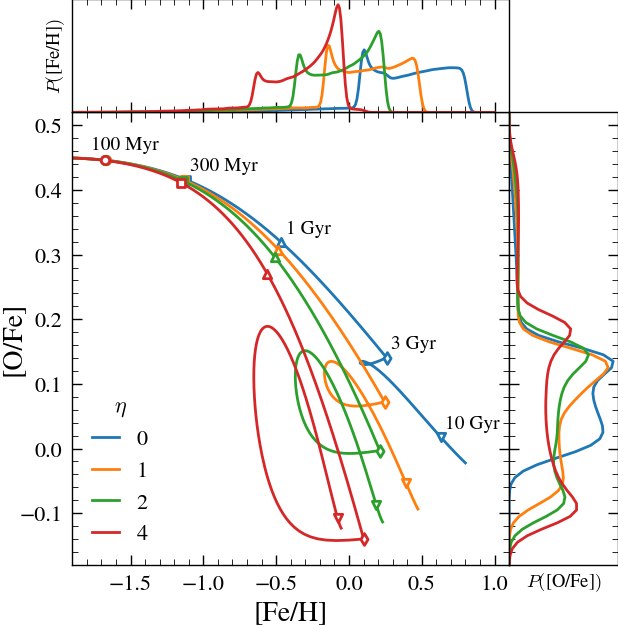

In [18]:
fig, axs = setup_figure(xlim=(-1.9, 1.1), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=3)

eta_list = [0, 1, 2, 4]
for eta in eta_list:
    name = str(output_dir / f'eta{eta}')
    ifr.ratio = twoinfall_ampratio(ifr, 8, onset=3, eta=eta)
    sz = setup_onezone(name, ifr, eta=eta)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{eta}',
                      marker_labels=(eta==0))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\eta$')
plt.show()

The mass-loading factor has a big influence on both the MDF and [O/Fe] DFs. A larger eta produces an MDF which is centered at lower metallicity, and produces [O/Fe] peaks which are farther apart.

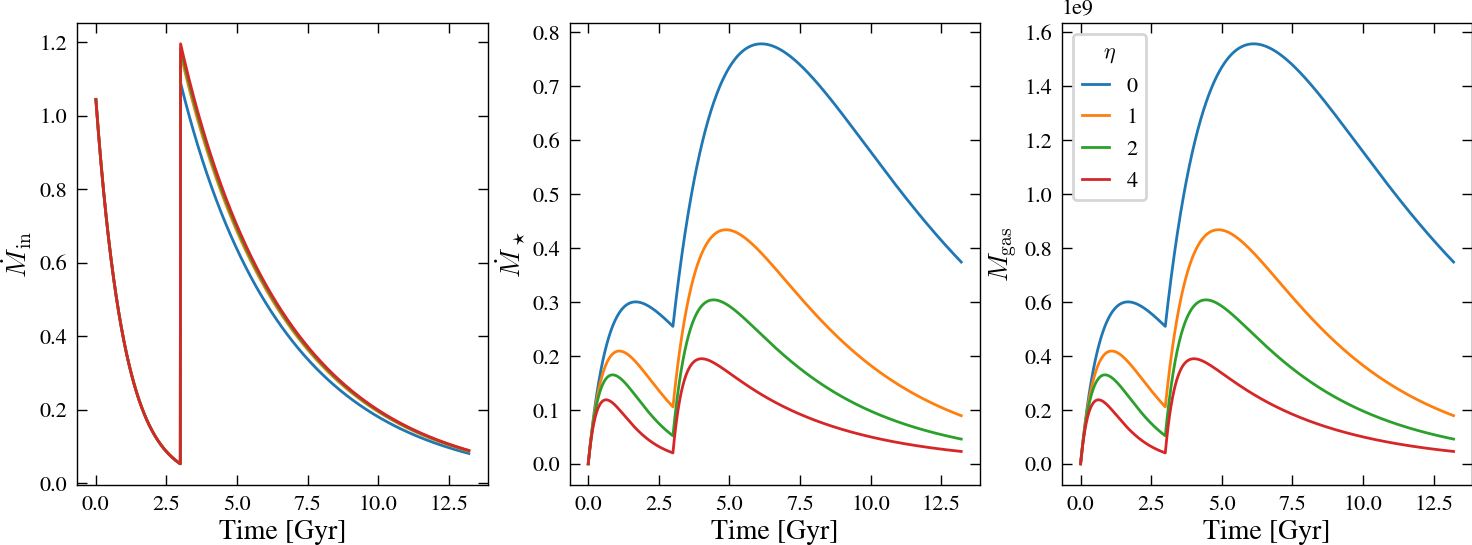

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
eta_list=[0, 1, 2, 4]
for eta in eta_list:
    name = str(output_dir / f'eta{eta}')
    hist = vice.history(name)
    axs[0].plot(hist['time'], hist['ifr'], '-')
    axs[1].plot(hist['time'], hist['sfr'], '-')
    axs[2].plot(hist['time'], hist['mgas'], '-', label=f'{eta}')
    
axs[2].legend(title=r'$\eta$')
for ax in axs:
    ax.set_xlabel('Time [Gyr]')
axs[0].set_ylabel(r'$\dot M_{\rm in}$')
axs[1].set_ylabel(r'$\dot M_\star$')
axs[2].set_ylabel(r'$M_{\rm gas}$')
plt.show()

## Pre-Enriched Gas Infall

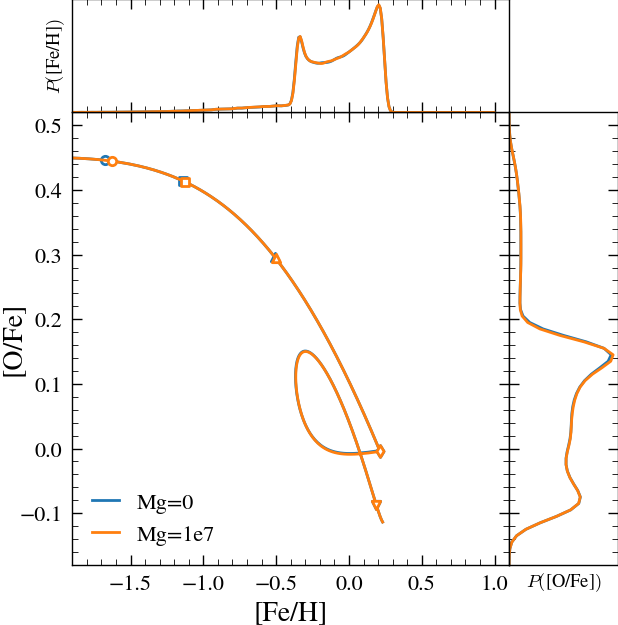

In [20]:
fig, axs = setup_figure(xlim=(-1.9, 1.1), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=3)
ifr.ratio = twoinfall_ampratio(ifr, 8, onset=3)

# No initial gas
name = str(output_dir / 'Mg0')
sz = setup_onezone(name, ifr)
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='Mg=0',
                  marker_labels=False)

# Initial gas mass equivalent to one infall timestep
name = str(output_dir / 'Mg1e7')
sz = setup_onezone(name, ifr)
sz.Mg0 = 1e7
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='Mg=1e7',
                  marker_labels=False)

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left')
plt.show()

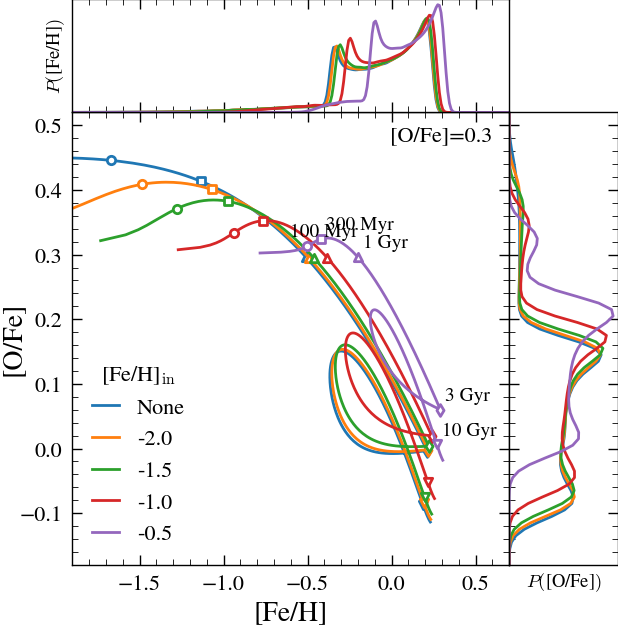

In [24]:
fig, axs = setup_figure(xlim=(-1.9, 0.7), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=3, second_timescale=4., first_timescale=1.)
ifr.ratio = twoinfall_ampratio(ifr, 8, onset=3)

# No infall enrichment
name = str(output_dir / 'ZinNone')
sz = setup_onezone(name, ifr, Zin=0.)
sz.Mg0 = 1e6
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='None',
                  marker_labels=False)

feh_list = [-2., -1.5, -1., -0.5]
Zin_list = [10 ** (feh + m.log10(vice.solar_z['fe'])) for feh in feh_list]
ofe_in = 0.3
Zo_in_list = [vice.solar_z['o'] * 10 ** (ofe_in + feh) for feh in feh_list]
for i, Zin in enumerate(Zin_list):
    name = str(output_dir / f'Zin{int(-10*feh_list[i]):02d}')
    sz = setup_onezone(name, ifr)
    sz.Zin = {'fe': Zin, 'o': Zo_in_list[i]}
    # Non-zero initial mass to avoid crazy high metallicities from inflow
    sz.Mg0 = 1e7
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{feh_list[i]}',
                      marker_labels=(i==3))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'[Fe/H]$_{\rm in}$')
axs[0].text(0.6, 0.5, f'[O/Fe]={ofe_in}', ha='right', va='top')
plt.show()

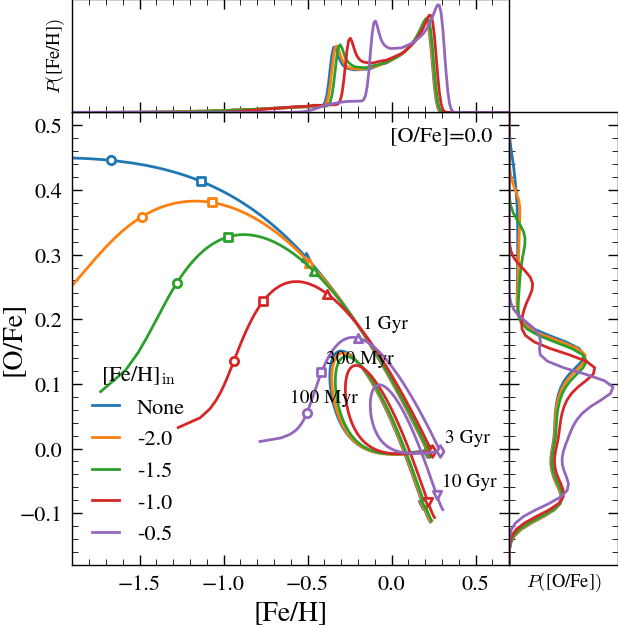

In [22]:
fig, axs = setup_figure(xlim=(-1.9, 0.7), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=3)
ifr.ratio = twoinfall_ampratio(ifr, 8, onset=3)

# No infall enrichment
name = str(output_dir / 'ZinNone')
sz = setup_onezone(name, ifr, Zin=0.)
sz.Mg0 = 1e6
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='None',
                  marker_labels=False)

feh_list = [-2., -1.5, -1., -0.5]
Zin_list = [10 ** (feh + m.log10(vice.solar_z['fe'])) for feh in feh_list]
ofe_in = 0.
Zo_in_list = [vice.solar_z['o'] * 10 ** (ofe_in + feh) for feh in feh_list]
for i, Zin in enumerate(Zin_list):
    name = str(output_dir / f'Zin{int(-10*feh_list[i]):02d}')
    sz = setup_onezone(name, ifr)
    sz.Zin = {'fe': Zin, 'o': Zo_in_list[i]}
    # Non-zero initial mass to avoid crazy high metallicities from inflow
    sz.Mg0 = 1e7
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{feh_list[i]}',
                      marker_labels=(i==3))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'[Fe/H]$_{\rm in}$')
axs[0].text(0.6, 0.5, f'[O/Fe]={ofe_in}', ha='right', va='top')
plt.show()

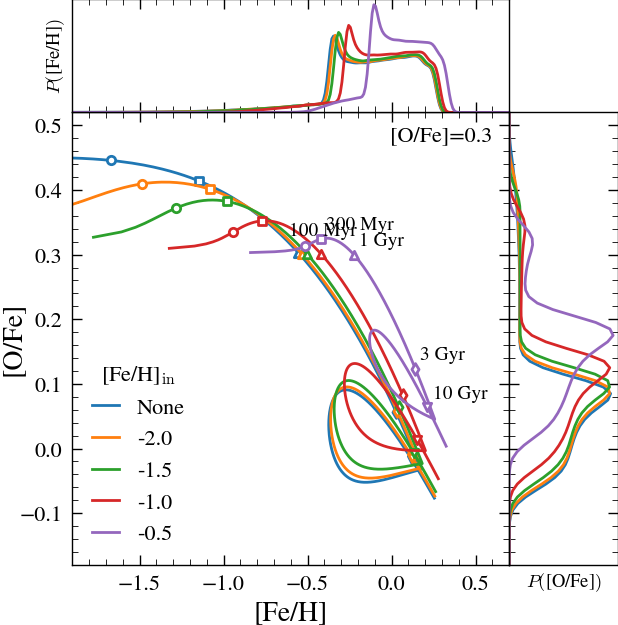

In [33]:
fig, axs = setup_figure(xlim=(-1.9, 0.7), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=4, second_timescale=4., first_timescale=2.)

# Variable tau_star
def tau_star_var(t, onset=4):
    if t < onset:
        return 2.
    else:
        return 4.

ifr.ratio = twoinfall_ampratio(ifr, 8, onset=4, tau_star=lambda time, mgas: tau_star_var(time))

# No infall enrichment
name = str(output_dir / 'ZinNone')
sz = setup_onezone(name, ifr, Zin=0.)
sz.tau_star = tau_star_var
sz.Mg0 = 1e6
sz.run(simtime, overwrite=True)
plot_vice_onezone(name, fig=fig, axs=axs,
                  label='None',
                  marker_labels=False)

feh_list = [-2., -1.5, -1., -0.5]
Zin_list = [10 ** (feh + m.log10(vice.solar_z['fe'])) for feh in feh_list]
ofe_in = 0.3
Zo_in_list = [vice.solar_z['o'] * 10 ** (ofe_in + feh) for feh in feh_list]
for i, Zin in enumerate(Zin_list):
    name = str(output_dir / f'Zin{int(-10*feh_list[i]):02d}')
    sz = setup_onezone(name, ifr)
    sz.tau_star = tau_star_var
    sz.Zin = {'fe': Zin, 'o': Zo_in_list[i]}
    # Non-zero initial mass to avoid crazy high metallicities from inflow
    sz.Mg0 = 1e7
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{feh_list[i]}',
                      marker_labels=(i==3))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'[Fe/H]$_{\rm in}$')
axs[0].text(0.6, 0.5, f'[O/Fe]={ofe_in}', ha='right', va='top')
plt.show()

## Trying to line up the two peaks with APOGEE

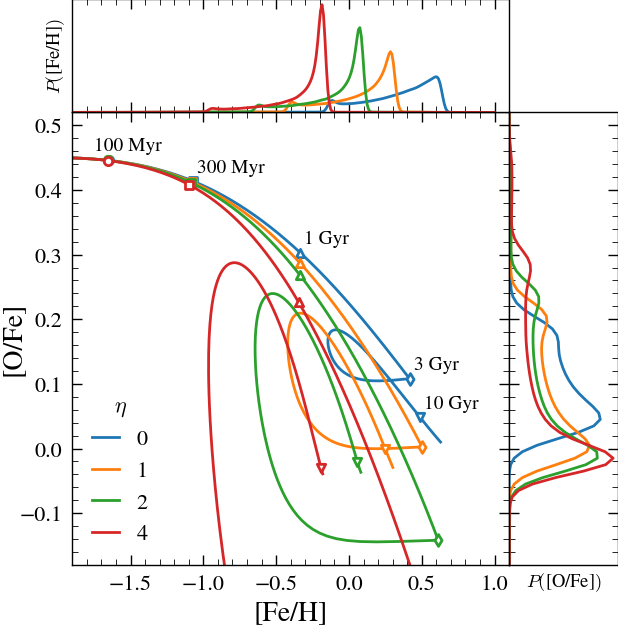

In [23]:
fig, axs = setup_figure(xlim=(-1.9, 1.1), ylim=(-0.18, 0.52))

ifr = twoinfall(8, onset=3, first_timescale=0.3, second_timescale=10)

eta_list = [0, 1, 2, 4]
for eta in eta_list:
    name = str(output_dir / f'eta{eta}')
    sz = setup_onezone(name, ifr, eta=eta, tau_star=2)
    sz.run(simtime, overwrite=True)
    plot_vice_onezone(name, fig=fig, axs=axs,
                      label=f'{eta}',
                      marker_labels=(eta==0))

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left', title=r'$\eta$')
plt.show()